In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
import torch
from permacache import stable_hash

import frame_alignment_checks as fac
from matplotlib import pyplot as plt

from render_psam import render_psams, render_psam

from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.manual_dfa.splice_site_dfa import splice_site_psam_pdfa
from orthogonal_dfa.psams.psam_pdfa import PSAMPDFA, PSAMPDFAWithTemperature
from orthogonal_dfa.psams.train import (
    identify_first_best_by_validation,
    train_psam_pdfa_full_learning_curve,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.oracle.run_model import create_dataset
from orthogonal_dfa.experiments.train_from_scratch import *
from orthogonal_dfa.module.residual_gate import *
from orthogonal_dfa.experiments.train_gate import (
    evaluate,
    train,
    train_multiple,
    evaluate_multiple,
    plot_linear_psam_gate,
)
from orthogonal_dfa.experiments.gate_experiments import train_mll, train_psam_linear
from orthogonal_dfa.manual_dfa.stop_codon_dfa import (
    stop_codon_from_psams,
    stop_codon_psamdfa,
    ZeroProbability,
)

In [4]:
def train_pdfa_wrt(test_dfa, control_gates):
    torch.manual_seed(0)
    gate, _ = train(
        InputMonotonicModelingGate(test_dfa, 5, 100).cuda(),
        1e-2,
        default_exon,
        oracle(),
        control_gates,
        epochs=10,
        batch_size=1000,
        train_count=100_000,
        seed=0,
        do_not_train_phi=True,
    )
    end, start = evaluate(
        default_exon, oracle(), control_gates, gate, count=100_000, seed=0
    )
    return start - end


def train_pdfa_wrt_all(test_dfa, control_gates):
    return np.array(
        [train_pdfa_wrt(test_dfa, control_gates[:i]) for i in range(len(control_gates))]
    )

In [5]:
gates_mll, _, results_mll = train_mll()

Training gate 1/5
Training gate 2/5
Training gate 3/5
Training gate 4/5
Training gate 5/5


In [6]:
gates_psams, _, results_psam = train_psam_linear(11)

Training gate 1/11
Training gate 2/11
Training gate 3/11
Training gate 4/11
Training gate 5/11
Training gate 6/11
Training gate 7/11
Training gate 8/11
Training gate 9/11
Training gate 10/11
Training gate 11/11


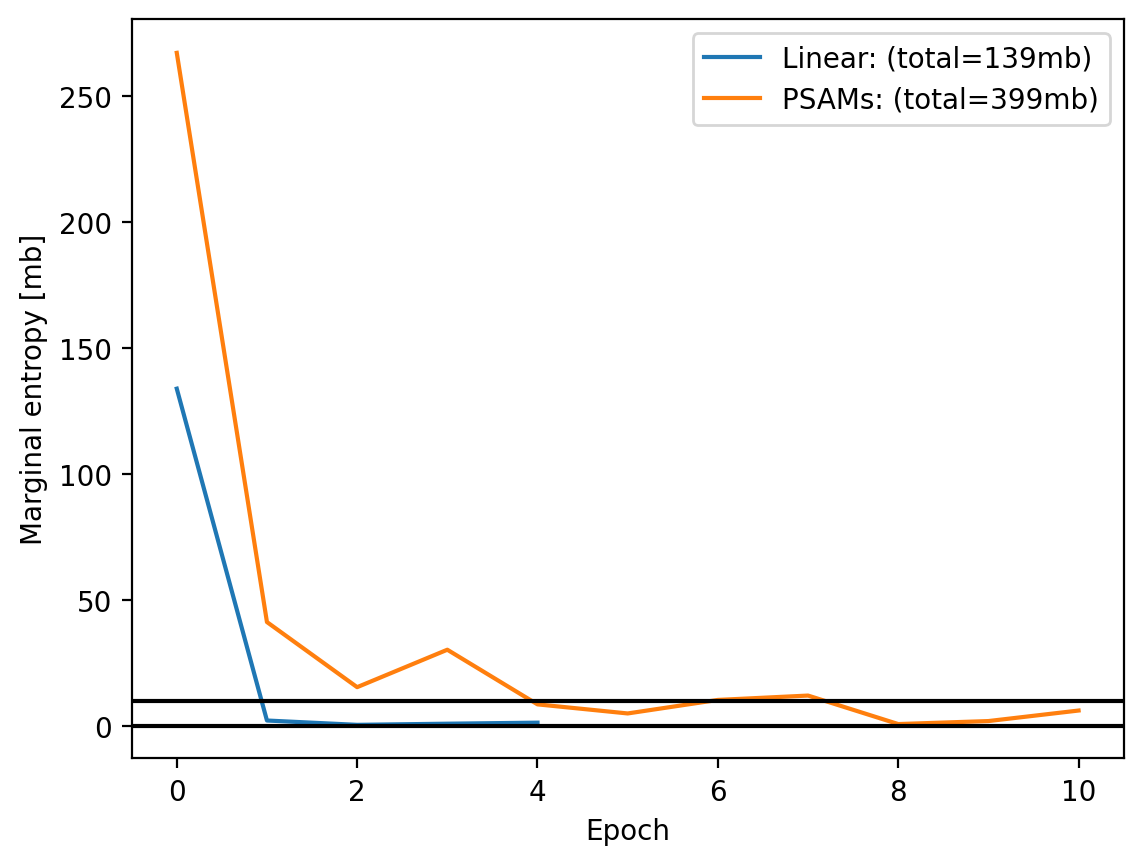

In [7]:
plt.figure(dpi=200)
plt.plot(results_mll * 1000, label=f"Linear: (total={results_mll.sum() * 1000:.0f}mb)")
plt.plot(results_psam * 1000, label=f"PSAMs: (total={results_psam.sum() * 1000:.0f}mb)")
plt.axhline(0, color="black")
plt.axhline(10, color="black")
plt.xlabel("Epoch")
plt.ylabel("Marginal entropy [mb]")
plt.legend()
plt.show()

In [8]:
from permacache import stable_hash

In [9]:
no_orf = stop_codon_psamdfa("TAG", "TAA", "TGA", zero_prob=ZeroProbability(1e-7)).cuda()
no_orf_ta = stop_codon_psamdfa("TAG", "TAA", zero_prob=ZeroProbability(1e-7)).cuda()

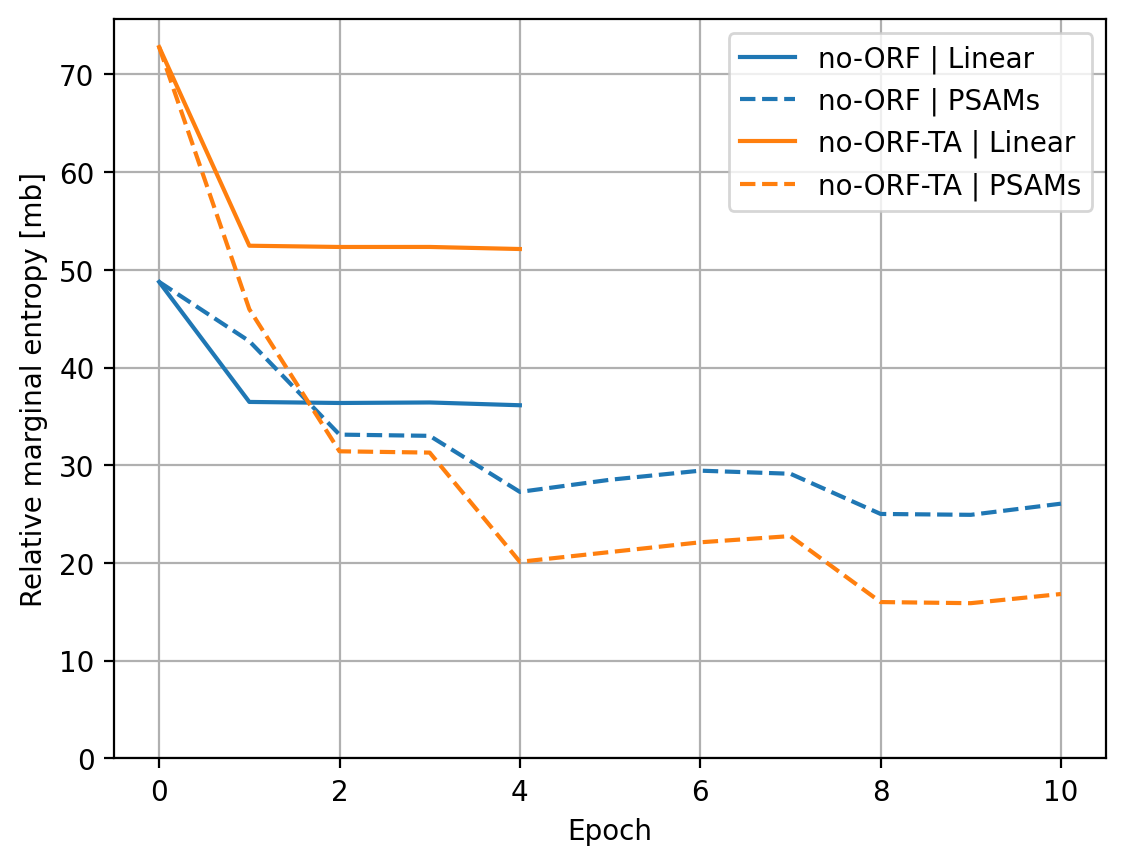

In [10]:
plt.figure(dpi=200)
plt.plot(
    1000 * train_pdfa_wrt_all(no_orf, gates_mll), label="no-ORF | Linear", color="C0"
)
plt.plot(
    1000 * train_pdfa_wrt_all(no_orf, gates_psams),
    label="no-ORF | PSAMs",
    color="C0",
    linestyle="--",
)
plt.plot(
    1000 * train_pdfa_wrt_all(no_orf_ta, gates_mll),
    label="no-ORF-TA | Linear",
    color="C1",
)
plt.plot(
    1000 * train_pdfa_wrt_all(no_orf_ta, gates_psams),
    label="no-ORF-TA | PSAMs",
    color="C1",
    linestyle="--",
)
plt.ylim(0, plt.ylim()[1])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Relative marginal entropy [mb]")
plt.grid()
plt.show()

In [11]:
def plot_all_psams(gates_trained):
    _, axs = plt.subplots(
        len(gates_trained), 3, figsize=(10, 3 * len(gates_trained)), tight_layout=True
    )
    for g, axs_row in zip(gates_trained, axs):
        plot_linear_psam_gate(g, *axs_row)

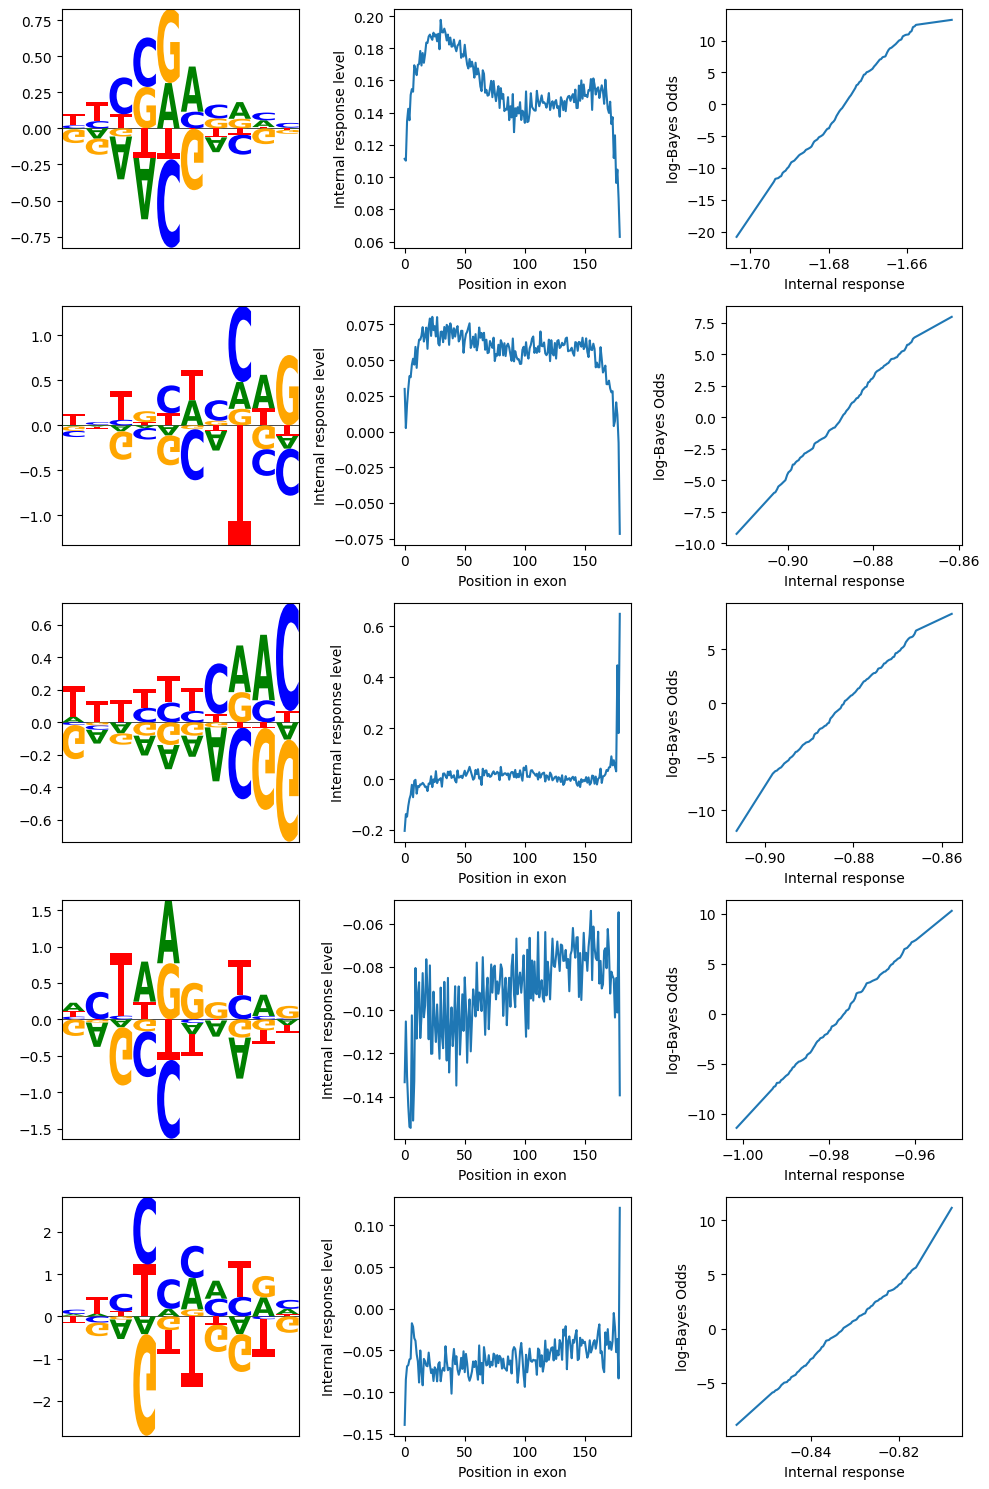

In [12]:
plot_all_psams(gates_psams[:5])